# Imports

In [3]:
import os, sys, glob, gc

SCRIPT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(os.path.dirname(SCRIPT_DIR))

from datetime import datetime, timedelta
import numpy as np
from scipy import interpolate

import matplotlib.pyplot as plt
from skimage.transform import rescale, resize

from classes import DataFile
from utils import load_object

# Data Analysis

## File List

Loading all 2019 files that contain link information at 14.3644 MHz.

In [4]:

file_list = load_object("data\\2019\\2019_14p3644.dat")

## One File

In [5]:
data_file = file_list[0]
print(data_file.date_time, data_file.link, data_file.frequency)

2019-07-20 00:00:00 ['Ale', 'Ott'] 14.3644


## Time Data

In [6]:
date = data_file.date_time
print(date)

time_of_day = data_file.data_dic['timeday']
print(time_of_day[:10])
print(time_of_day.shape)


2019-07-20 00:00:00
[737626.69190972 737626.69885417 737626.70059028 737626.70232639
 737626.7040625  737626.70579861 737626.70753472 737626.70927083
 737626.71100694 737626.71274306]
(175,)


In [7]:
time_of_day = time_of_day.ravel()
time_of_day[:10]

array([737626.69190972, 737626.69885417, 737626.70059028, 737626.70232639,
       737626.7040625 , 737626.70579861, 737626.70753472, 737626.70927083,
       737626.71100694, 737626.71274306])

This suggests that everything before the decimal is just the day. The fraction might be the time of day, as the variable in the raw data is named `timeday`.


In [8]:
next_day_data =  file_list[1]
print(next_day_data.date_time)

n_time_data = next_day_data.data_dic['timeday'].ravel()
print(n_time_data[:10])

2019-07-21 00:00:00
[737627.00267361 737627.00440972 737627.00614583 737627.00788194
 737627.00961806 737627.01135417 737627.01309028 737627.01482639
 737627.0165625  737627.01829861]


This makes sense but what is the reference day...?

In [9]:
days_since = int(np.floor(n_time_data[0]))
days_since

737627

In [10]:
print(next_day_data.date_time)
print(datetime(1, 1, 1) + timedelta(days=days_since))

2019-07-21 00:00:00
2020-07-22 00:00:00


Okay. So their reference is year 0, day 0. The begining of time lol.

### Other time data

- TOFLIGHT: Time of flight in [ms].
- TOFMODE: Modelled time of flight [ms]. (as referring to the ray tracing in the paper).

## Power Data

There's `snr`, `snr_dd`, and `sigpow` attributes in the data. All the data have 175 columns (can be though of as entries, and vary with each day and frequency- sometimes we have more/less data in a given day). 

Luckily, a lot of the units here can be verified with Taylor's paper. From the paper, we have the following:

- SNR [dB]
- SIG POW [dBm] (referenced to milli-Watts)
- SNR_DD [dimensionless] -- Has to be related to the probablility **d**ensity **d**istributions in the paper. However, in the paper they are normalized between 0 and 1.

In [11]:
snr = data_file.data_dic['snr']

### Signal Power

By inverting signal power, assuming the units were $dBm$, we can see that the mean value is about $ 4.6 \times 10^{5} \ kW $. In comparison, HAARP outputs ~ $3.6 \times 10^{3} ~ kW$ or ~ $ 95.5 ~ dBm $. It only makes sense that these are referenced to the noise floor, which is confirmed when looking at Taylor's paper: ***he uses negative values***. 

In [12]:
sig_pow = 1e-3*np.power(data_file.data_dic['sigpow']/10, 10)
print(sig_pow[:3], "%.2e" % np.mean(sig_pow))

[4.18521542e+08 3.38566836e+07 9.03023567e+06] 4.61e+08


### SNR_DD

These must be the density distributions that Taylor used in his paper. We can check by reproducing his 2014, 14.36 MHz plot. 


<img src="snr_dd_5mhz.png">

#### Slice one day

In [13]:
files_2014 = load_object("data\\2014\\2014_5p3820.dat")

In [14]:
file = files_2014[0]

file.data_dic['timeday']

array([735600.24104167, 735600.25145833, 735600.99104167])

In [15]:

norm = np.linspace(0, 1, endpoint=True, num=1000)
norm_day = np.linspace(0, 24, endpoint=True, num=1000)

f =  interpolate.interp1d( norm, norm_day  )

In [16]:
time_arr = file.data_dic['timeday']

def strip_day_from_time(day_time):

    return day_time - np.floor(day_time)

time_arr = np.vectorize(strip_day_from_time)(time_arr)
time_arr

array([0.24104167, 0.25145833, 0.99104167])

In [17]:
f(time_arr)

array([ 5.785,  6.035, 23.785])

In [18]:
snr_dd = file.data_dic["snr_dd"]

print(snr_dd)
print(f(time_arr).shape, snr_dd.shape)

[0.49095363 0.58715367 0.57982358]
(3,) (3,)


In [19]:
binned_day = np.arange(0, 24, 0.5 )

def bin_time(time):

    indcs = np.where( np.isclose(time, binned_day, atol=0.3) )[0]

    # Bin OVerlap Condition
    if len(indcs) == 1:
        return binned_day[indcs]
        
    elif len(indcs) > 1:

        # Edge Case
        if indcs[-1] == 47:

            # Use 23.5 hr bin
            return binned_day[indcs[-1]]

        else: return binned_day[indcs[0]]


    return binned_day[indcs] if len(indcs) == 1 else binned_day[indcs[-1]] 

interp_t_arr = f(time_arr)
print(interp_t_arr)
binned_t_arr = np.vectorize(bin_time)(interp_t_arr)
binned_t_arr


[ 5.785  6.035 23.785]


array([ 5.5,  6. , 23.5])

In [20]:
time_slice = np.zeros_like(binned_day)
print(binned_day)
print(binned_t_arr, binned_t_arr.shape)

indcs = np.searchsorted(  binned_day, binned_t_arr, side="left" )

[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5]
[ 5.5  6.  23.5] (3,)


In [21]:
indcs

array([11, 12, 47], dtype=int64)

In [22]:
def stack_bins(indcs, time_slice, values_arr):
    """ For values in the same time bin, average them."""

    unique, dup_count = np.unique(indcs, return_counts=True)
    dup = unique[dup_count > 1]

    # If there's duplicates
    means = []
    if len(dup) >= 1:
        
        # Get their mean
        for d in dup:
            i = np.where( np.in1d(indcs, d) )[0]
            mean = np.mean(values_arr[i])
            means.append(mean)        

    # Place values in time slice
    time_slice[indcs] = values_arr
    time_slice[dup] = np.array(means)

    return time_slice

stack_bins(indcs, time_slice, snr_dd)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.49095363, 0.58715367, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.57982358])

#### Put it all together

In [23]:

months = []
for file_indx, file in enumerate(files_2014):

    # Month of year
    month = file.date_time.month
    months.append(month)

    # Repeat previous steps for entire year
    timeday_arr = file.data_dic['timeday']
    
    t_arr = np.vectorize(strip_day_from_time)(timeday_arr)

    interp_t_arr = f(t_arr) 
    binned_t_arr = np.vectorize(bin_time)(interp_t_arr)

    time_slice = np.zeros_like(binned_day)
    indcs = np.searchsorted(  binned_day, binned_t_arr, side="left" )


    snr_dd = file.data_dic["snr_dd"]

    time_slice = stack_bins(indcs, time_slice, snr_dd)

    # Construct image
    if file_indx == 0: time_slices = time_slice
    else: time_slices = np.vstack( (time_slices, time_slice) )

months = np.unique(months)
print(months)

[ 1  2  3  4  5  6  7  8  9 10]


In [24]:
from matplotlib.colors import Normalize

norm = Normalize(vmin=0, vmax=1, clip=False)



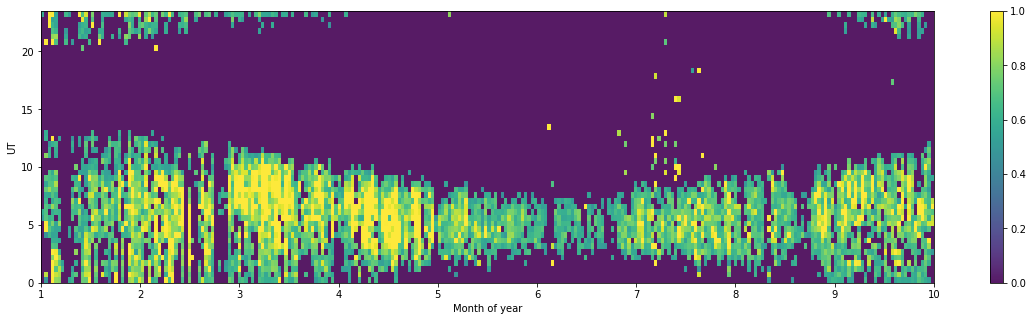

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(20,5) )

xlim = tuple(months[[0, -1]])
ylim = tuple(binned_day[[0, -1]])

im = ax.imshow(np.flipud(time_slices.T), norm=norm, alpha=0.9, extent=[*xlim, *ylim], aspect="auto", interpolation='None', )

ax.set_xlabel(  "Month of year"  )
ax.set_ylabel( "UT")

fig.colorbar(im)

We are very close. After inspecting Taylor's plot closely, I can see that he grouped up the months in roughly 4 bins. Let's try that out.

In [26]:
image = np.flipud(time_slices.T)
x_shape, y_shape = image.shape
print(x_shape, y_shape)

downsize_image = resize( image, (x_shape, y_shape//4), preserve_range=True, order=3, anti_aliasing=True )
print(downsize_image.shape)


48 268
(48, 67)


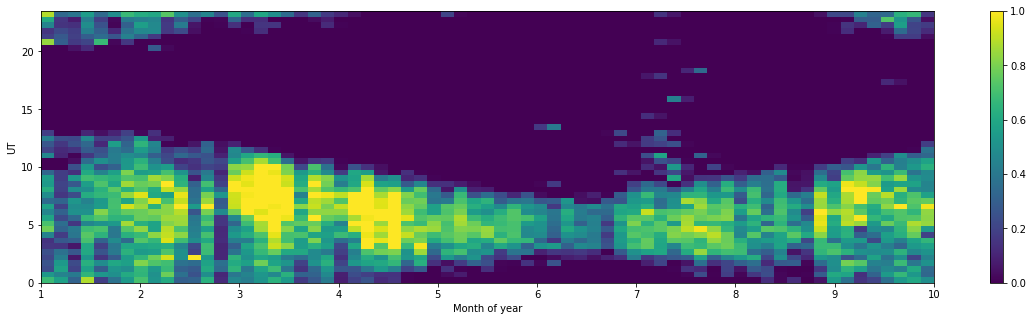

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(20,5) )
im = ax.imshow(downsize_image, norm=norm, alpha=1, extent=[*xlim, *ylim], aspect="auto", interpolation='none' )

ax.set_xlabel(  "Month of year"  )
ax.set_ylabel( "UT")

fig.colorbar(im)